In [76]:
""" 
Build a text classification model on song lyrics. First, we scrap lyrics.com for two artists' (artist name input by hand)
lyrics. Following, vectorization on the lyrics corpus is performed and a variety of classification models
are compared. The result is a ML model which predicts, for any user given sentence, which artist most likely used
this sentence in their lyrics.
"""

" \nBuild a text classification model on song lyrics. First, we scrap lyrics.com for two artists' (artist name input by hand)\nlyrics. Following, vectorization on the lyrics corpus is performed and a variety of classification models\nare compared. The result is a ML model which predicts, for any user given sentence, which artist most likely used\nthis sentence in their lyrics.\n"

In [77]:
%reset -f
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import requests
import re
from bs4 import BeautifulSoup
import os
import numpy as np
from scipy.stats import uniform
import urllib.parse

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb


# 1. Web Scrapping  & Processing of the Corpus

In [78]:
def get_hyperlinks(artist):
    """ Crawl lyrics.com, extract the hyperlinks for every song listed under a specified artist"""
    #get all lyric-hyperlinks for specific artist
    r = requests.get('https://www.lyrics.com/artist' + artist)
    text = r.text # get all beach boy songs in html
    pattern = r"<a href=\"\/lyric\/(.*?)\">"
    text_extracted = re.findall(pattern, text) # get all hyperlinks to lyrics
    hyperlinks = ['https://www.lyrics.com/lyric/' + s for s in text_extracted] # create proper addresses
    return hyperlinks

def get_unique_hyperlinks(hyperlinks, search_word):
    """ Scan the complete list of artist hyperlinks and removes all duplicate songs, e.g. song1 and
    song1 [Stereo] to only extract song1 once. Returns a list of unique hyperlinks and corresponing song names.
    
    Arg: search_word...specify the string in the lyrics-URL before the song name starts. Needs to be looked up manually"""
    # clean the song titles
    pattern = '(?<=' + search_word + '/).*'
    song_titles = [re.findall(pattern, link)[0] for link in hyperlinks] # extract song titles
    song_titles = [urllib.parse.unquote_plus(title) for title in song_titles] # remove % symbols
    song_titles = [re.search(r"[^\[\]]*", title)[0] for title in song_titles] # remove brackets like [Mono]
    song_titles = [re.search(r"[^()]*", title)[0] for title in song_titles] # remove brackets like (Track #1)
    song_titles = [remove_punc_generator(title) for title in song_titles] # remove special characters
    song_titles = [title.lower() for title in song_titles] # make everything lower case
    song_titles = [re.sub(r"[ \t]+$", '', title) for title in song_titles]  #remove trailing white spaces
    song_titles = [re.sub(r"'", '', title) for title in song_titles]  # remove ' symbols
    # find unique song titles
    unique_songs = []
    idx = -1
    idx_list =[]
    for song in song_titles:
        idx += 1
        if song not in unique_songs:
            unique_songs.append(song)
            idx_list.append(idx)
    unique_links = [hyperlinks[idx] for idx in idx_list]
    return unique_links, unique_songs

def save_lyrics(hyperlinks, save_folder):
    """ Save lyrics for each link/song into a file. If save_folder doesn't already exist, it will be created."""
    os.makedirs("./output/" + save_folder, exist_ok=True) 
    counter = 0
    for link in hyperlinks:
        try: # some links dont contain lyrics, skip them
            counter += 1
            ## download lyrics for each link and save to file
            r = requests.get(link)
            text = r.text # get lyrics as html
            soup = BeautifulSoup(text)
            soup = soup.find(id="lyric-body-text") # get lyrics text block
            lyrics = soup.get_text()
            lyrics = lyrics.replace("\r", "")
            lyrics = lyrics.replace("\n", " ")
            # save to file
            f = open("./output/"+ save_folder + "/lyric" + str(counter) + ".txt", "w")
            f.write(lyrics)
            f.close()
            print(f'Saving file nr. {counter}  out of {len(hyperlinks)} in folder {save_folder} complete.')
        except:
            pass
    return True

def remove_punc_generator(string):
    punc = ".!’‘()-[]{};,:?@#$%^&*_\"~"
    for element in string:  
        if element in punc:  
            string = string.replace(element, "") 
    return string

def create_corpus(save_folder):
    """ Loads all created lyric files, cleans them up and outputs the pre-processed corpus."""
    corpus = []
    #load data
    for filename in os.listdir('./output/'+save_folder):
        with open(os.path.join('./output/'+save_folder, filename), 'r') as f: # open in readonly mode
            data = f.read()
            f.close()
            data = data.lower() # make all strings lowercase
            data = remove_punc_generator(data) #remove punctuation defined above
            data = data.replace("'", "")
            data = data.replace("cause", "because")
            corpus.append(data)
    return corpus


In [79]:
download_switch = 0 # set = 0 if you already have your lyrics data previously downloaded and saved

if download_switch != 0:
    # download artist1
    hyperlinks = get_hyperlinks('/The-Beach-Boys/3640')
    search_word = 'Boys'
    unique_hyperlinks, _ = get_unique_hyperlinks(hyperlinks, search_word)
    save_folder = 'beachboys'
    save_lyrics(unique_hyperlinks, save_folder)
    # download artist2
    hyperlinks = get_hyperlinks('/Pretenders/5177')
    search_word = 'Pretenders'
    unique_hyperlinks, _ = get_unique_hyperlinks(hyperlinks, search_word)
    save_folder = 'pretenders'
    save_lyrics(unique_hyperlinks, save_folder)


In [80]:
#clean data and create corpus
save_folder = 'beachboys'
artist1_corpus = create_corpus(save_folder)
save_folder = 'pretenders'
artist2_corpus = create_corpus(save_folder)

In [81]:
labels = ['BeachBoys'] * len(artist1_corpus) + ['Pretenders'] * len(artist2_corpus)
text = artist1_corpus+artist2_corpus
lyrics = pd.DataFrame({'text':text ,'artist': labels})

In [82]:
# vectorize your corpus
vectorizer = TfidfVectorizer(stop_words=['english'], min_df=2, max_df=0.7)
X_text = vectorizer.fit_transform(text)
lyrics_vectorized_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out(), index=labels)

# 2. Model Building

In [83]:
X = X_text
y = labels
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [84]:
model_label = []
estimator = []
best_cv_score = []
best_accuracy_score = []
example_prob_result = []
nonsense_prob_result = []
# define parameters for ALL grid searches
n_iter = 25
scoring = 'accuracy' 
cv = 5  
verbose = 1
return_train_score = False
random_state = 0
n_jobs = -1
example_sentence = ["Surfin' is life The only way"] # test: choose a sentence which is closely related to a lyric, but not contained in training/testing set
nonsense_sentence = ["hretge ervergg t434geeg"] # a nonsensical string that is NOT inside the corpus

### Logistic Regression

In [85]:
model_label.append('logistic')
classifier = LogisticRegression(max_iter=10000, random_state=False)
pipe = Pipeline(steps=[("logistic", classifier)])

# set up param distributions for grid search
param_dist = {
    "logistic__C": uniform(loc=0, scale=4).rvs(size=100), #set how many random values to generate
    "logistic__tol": [1e-4, 1e-3, 1e-2, 1e-1],
    "logistic__fit_intercept": [False, True],
    "logistic__penalty": ['l2'],
}
search = RandomizedSearchCV(pipe, param_dist, n_iter= n_iter, scoring=scoring,
                            cv=cv, verbose=verbose, return_train_score=return_train_score,
                            random_state=random_state, n_jobs=n_jobs)

search.fit(X_train, y_train)

print("Best parameter for grid search (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)
print("Training Set performance: ")
y_pred = search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))
#save data for model comparison later
estimator.append(search.best_estimator_)
best_cv_score.append(search.best_score_)
best_accuracy_score.append(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameter for grid search (CV score=0.7989):
{'logistic__tol': 0.01, 'logistic__penalty': 'l2', 'logistic__fit_intercept': False, 'logistic__C': 2.9320224312424283}
Training Set performance: 
0.7938144329896907


In [86]:
example_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

nonsense_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

[[0.72372544 0.27627456]]
['BeachBoys' 'Pretenders']
[[0.5 0.5]]
['BeachBoys' 'Pretenders']


### Naive Bayes

In [87]:
model_label.append('bayes')
classifier = MultinomialNB(fit_prior=False)
pipe = Pipeline(steps=[("bayes", classifier)])

# set up param distributions for grid search
param_dist = {
    "bayes__alpha": uniform(loc=0, scale=2).rvs(size=500), #set how many random values to generate
}
search = RandomizedSearchCV(pipe, param_dist, n_iter= n_iter, scoring=scoring,
                            cv=cv, verbose=verbose, return_train_score=return_train_score,
                            random_state=random_state, n_jobs=n_jobs)

search.fit(X_train, y_train)

print("Best parameter for grid search (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)
print("Training Set performance: ")
y_pred = search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))
#save data for model comparison later
estimator.append(search.best_estimator_)
best_cv_score.append(search.best_score_)
best_accuracy_score.append(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameter for grid search (CV score=0.8324):
{'bayes__alpha': 0.0686256783673862}
Training Set performance: 
0.8041237113402062


In [88]:
example_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

nonsense_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

[[0.88708726 0.11291274]]
['BeachBoys' 'Pretenders']
[[0.5 0.5]]
['BeachBoys' 'Pretenders']


### K-Nearest Neighbour

In [89]:
model_label.append('knn')
classifier = KNeighborsClassifier(metric='euclidean')
pipe = Pipeline(steps=[("knn", classifier)])

# set up param distributions for grid search
param_dist = {
    "knn__p": list(range(1,4,1)), 
    "knn__n_neighbors": list(range(1,25,1)), 
    "knn__leaf_size": list(range(1,100,1)), 
}
search = RandomizedSearchCV(pipe, param_dist, n_iter= n_iter, scoring=scoring,
                            cv=cv, verbose=verbose, return_train_score=return_train_score,
                            random_state=random_state, n_jobs=n_jobs)

search.fit(X_train, y_train)

print("Best parameter for grid search (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)
print("Training Set performance: ")
y_pred = search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))
#save data for model comparison later
estimator.append(search.best_estimator_)
best_cv_score.append(search.best_score_)
best_accuracy_score.append(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameter for grid search (CV score=0.7758):
{'knn__p': 1, 'knn__n_neighbors': 17, 'knn__leaf_size': 94}
Training Set performance: 
0.7628865979381443


In [90]:
example_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

nonsense_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

[[0.76470588 0.23529412]]
['BeachBoys' 'Pretenders']
[[0.94117647 0.05882353]]
['BeachBoys' 'Pretenders']


### SVM

In [91]:
model_label.append('svm')
classifier = SVC(probability=True, random_state=0)
pipe = Pipeline(steps=[("svm", classifier)])

# set up param distributions for grid search
param_dist = {
    "svm__C": uniform(loc=0, scale=5).rvs(size=50),
    "svm__kernel": ['linear', 'poly', 'rbf'],
    "svm__degree": [2, 3, 4, 5],
    "svm__gamma": uniform(loc=0, scale=2).rvs(size=25),
}
search = RandomizedSearchCV(pipe, param_dist, n_iter=n_iter, scoring=scoring,
                            cv=cv, verbose=verbose, return_train_score=return_train_score,
                            random_state=random_state, n_jobs=n_jobs)

search.fit(X_train, y_train)

print("Best parameter for grid search (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)
print("Training Set performance: ")
y_pred = search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))
#save data for model comparison later
estimator.append(search.best_estimator_)
best_cv_score.append(search.best_score_)
best_accuracy_score.append(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameter for grid search (CV score=0.8092):
{'svm__kernel': 'linear', 'svm__gamma': 0.12231334616724343, 'svm__degree': 4, 'svm__C': 2.121447063452565}
Training Set performance: 
0.865979381443299


In [92]:
example_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

nonsense_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

[[0.89443448 0.10556552]]
['BeachBoys' 'Pretenders']
[[0.86833223 0.13166777]]
['BeachBoys' 'Pretenders']


### Decision Tree

In [93]:
model_label.append('decisiontree')
classifier = DecisionTreeClassifier(random_state=0)
pipe = Pipeline(steps=[("decisiontree", classifier)])

# set up param distributions for grid search
param_dist = {
    "decisiontree__criterion": ['gini', 'entropy', 'log_loss'],
    "decisiontree__max_depth": list(range(1,50,1)),
}
search = RandomizedSearchCV(pipe, param_dist, n_iter= n_iter, scoring=scoring,
                            cv=cv, verbose=verbose, return_train_score=return_train_score,
                            random_state=random_state, n_jobs=n_jobs)

search.fit(X_train, y_train)

print("Best parameter for grid search (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)
print("Training Set performance: ")
y_pred = search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))
#save data for model comparison later
estimator.append(search.best_estimator_)
best_cv_score.append(search.best_score_)
best_accuracy_score.append(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameter for grid search (CV score=0.7629):
{'decisiontree__max_depth': 8, 'decisiontree__criterion': 'gini'}
Training Set performance: 
0.8144329896907216


In [94]:
example_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

nonsense_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

[[0.91258741 0.08741259]]
['BeachBoys' 'Pretenders']
[[0.91258741 0.08741259]]
['BeachBoys' 'Pretenders']


### Random Forest

In [95]:
model_label.append('randomforest')
classifier = RandomForestClassifier(random_state=0)
pipe = Pipeline(steps=[("randomforest", classifier)])

# set up param distributions for grid search
param_dist = {
    "randomforest__criterion": ['gini'],
    "randomforest__n_estimators": list(range(1,600,2)),
    "randomforest__max_depth": list(range(1,80,1)),
}
search = RandomizedSearchCV(pipe, param_dist, n_iter= n_iter, scoring=scoring,
                            cv=cv, verbose=verbose, return_train_score=return_train_score,
                            random_state=random_state, n_jobs=n_jobs)

search.fit(X_train, y_train)

print("Best parameter for grid search (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)
print("Training Set performance: ")
y_pred = search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))
#save data for model comparison later
estimator.append(search.best_estimator_)
best_cv_score.append(search.best_score_)
best_accuracy_score.append(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameter for grid search (CV score=0.7861):
{'randomforest__n_estimators': 167, 'randomforest__max_depth': 64, 'randomforest__criterion': 'gini'}
Training Set performance: 
0.7938144329896907


In [96]:
example_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

nonsense_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

[[0.69461078 0.30538922]]
['BeachBoys' 'Pretenders']
[[0.62275449 0.37724551]]
['BeachBoys' 'Pretenders']


### LightGBM

In [97]:
model_label.append('lgb')
classifier = lgb.LGBMClassifier(random_state=0)
pipe = Pipeline(steps=[('lgb', classifier)])

# set up param distributions for grid search
param_dist = {
    "lgb__n_estimators": np.arange(1,500,2),
    "lgb__max_depth": np.arange(1,50,1), # -1 == no limit
    "lgb__num_leaves": np.arange(2,100,2), # -1 == no limit
    "lgb__boosting_type": ['gbdt'], #'dart', 'goss', 'rf'
    "lgb__learning_rate": uniform(loc=0.0001, scale=0.3).rvs(50),
}                      

search = RandomizedSearchCV(pipe, param_dist, n_iter= n_iter, scoring=scoring,
                            cv=cv, return_train_score=return_train_score,
                            verbose=verbose, random_state=random_state, n_jobs=n_jobs)

search.fit(X_train, y_train)

print("Best parameter for grid search (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)
print("Training Set performance: ")
y_pred = search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))
#save data for model comparison later
estimator.append(search.best_estimator_)
best_cv_score.append(search.best_score_)
best_accuracy_score.append(accuracy_score(y_test, y_pred))

# # check cross-validation
# results = cross_val_score(regressor, X, y, cv=5, verbose=4, scoring='neg_mean_squared_log_error')
# print(results.mean())
# print(f'CV mean RMSLE: {np.sqrt(-results.mean())}')


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameter for grid search (CV score=0.8017):
{'lgb__num_leaves': 24, 'lgb__n_estimators': 271, 'lgb__max_depth': 25, 'lgb__learning_rate': 0.2388357961946049, 'lgb__boosting_type': 'gbdt'}
Training Set performance: 
0.7938144329896907


In [98]:
example_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(example_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

nonsense_prob_result.append(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray()))
print(estimator[-1].predict_proba(vectorizer.transform(nonsense_sentence).toarray())) #make a single, custom prediction
print(estimator[-1].classes_)

[[0.00484729 0.99515271]]
['BeachBoys' 'Pretenders']
[[0.00100323 0.99899677]]
['BeachBoys' 'Pretenders']


# 3. Model Comparison

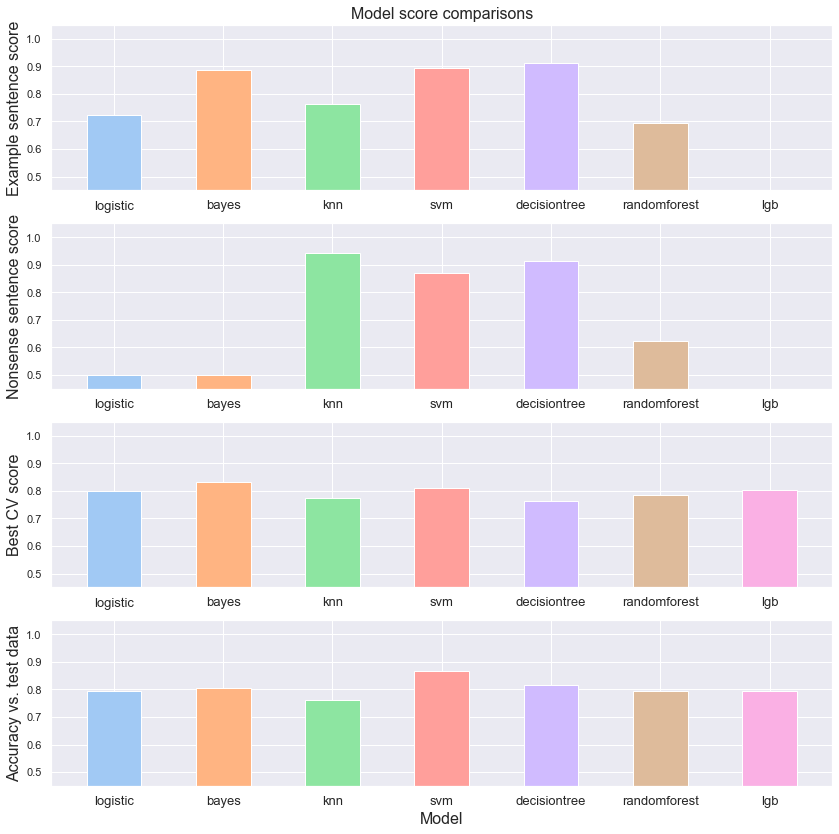

In [127]:
example_prob = [example_prob_result[_][0][0] for _ in range(len(example_prob_result))] # extract prediction prob. for example sentence
nonsense_prob = [nonsense_prob_result[_][0][0] for _ in range(len(nonsense_prob_result))] # extract prediction prob. for example sentence

fig, axs = plt.subplots(4, 1, figsize=(14,14), sharey=True)
colors = sns.color_palette("pastel")

axs[0].set_title("Model score comparisons", fontsize=16)

axs[0].bar(x=range(len(model_label)), height=example_prob, width=0.5, color=colors)
axs[1].bar(x=range(len(model_label)), height=nonsense_prob, width=0.5, color=colors)
axs[2].bar(x=range(len(model_label)), height=best_cv_score, width=0.5, color=colors)
axs[3].bar(x=range(len(model_label)), height=best_accuracy_score, width=0.5, color=colors)

for i in range(4):
    axs[i].set_xticks(range(len(model_label)))
    axs[i].set_xticklabels(labels=model_label, fontsize=13, rotation=0)

axs[3].set_xlabel("Model", fontsize=16)

axs[0].set_ylabel("Example sentence score", fontsize=16)
axs[1].set_ylabel("Nonsense sentence score", fontsize=16)
axs[2].set_ylabel("Best CV score", fontsize=16)
axs[3].set_ylabel("Accuracy vs. test data", fontsize=16)

axs[0].set_ylim([0.45,1.05])

plt.show()

# 4. Final Model \& Prediction

In [125]:
## based on the results above, the SVM finds the best balance between very good test set performance,
## and not overfitting the nonsense predictions
model = estimator[3]

your_sentence = ["dont get this wrong"] # type in your sentence to search for
prob = model.predict_proba(vectorizer.transform(your_sentence).toarray()).max().round(2)
pred = model.predict(vectorizer.transform(your_sentence).toarray())

print(f"The sentence \"{your_sentence[0]}\" belongs to the artist {pred[0]} with a {prob}% probability.")


The sentence "dont get this wrong" belongs to the artist Pretenders with a 0.85% probability.
